# CS109b Final Project: 
# Air Pollution Exposure and COVID-19 Mortality in the U.S.

## Import libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Load and clean data

In [2]:
data = pd.read_csv("./../PM_COVID-master/processed_data_04-24-2020.csv")

In [3]:
#load data
#data = pd.read_csv('https://raw.githubusercontent.com/CS109b-Team37/Pollution-Prediction/master/PM_COVID-master/processed_data_04-24-2020.csv')

In [4]:
#rename older_pecent to older_percent
data = data.rename(columns={'older_pecent': 'older_percent'})

#drop columns
cols = list(data.columns)
cols.remove('Unnamed: 0') #just a column of integers 1-21560
#cols.remove('Province_State') #redundant information; already captured by 'state'
cols.remove('Country_Region') #only US
cols.remove('Combined_Key') #redundant information; already captured by 'Province_State' and 'Admin2'
cols.remove('year.x') #only 2016
cols.remove('year.y') #only 2012 and nan
cols.remove('Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('older_Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('date') #only 20200502
cols.remove('hash') #useless information
cols.remove('dateChecked') #only '2020-05-02T20:00:00Z'
cols.remove('Abbrev') #redundant information; already captured by 'state'
cols.remove('total') #almost a repeat of 'totalTestResults'
cols.remove('Recovered') #only 0
data = data[cols]


In [5]:
data['Last_Update'].unique()

array(['2020-04-25 06:30:53', '3/30/20 22:52', '2020-04-25 06:31:05',
       '2020-04-23 00:00:00', '2020-04-24 00:00:00'], dtype=object)

In [6]:
#convert Last_Update to binary variable
convert_dict = {'2020-05-03 02:32:28': 0, '3/30/20 22:52': 1}
data = data.replace({'Last_Update': convert_dict})


In [7]:
#variables with NA values
print('Variables with NA values:')
display(data.isna().sum()[data.isna().sum() > 0])

#remove variables with many NA values
na_vars = list(data.isna().sum()[data.isna().sum() > 50].index) #variables with many NA values
data = data[set(cols) - set(na_vars)] #final cleaned data

Variables with NA values:


smoke_rate                 867
mean_bmi                   867
Crude.Rate                   1
older_percent                1
pending                   2819
hospitalizedCurrently      898
hospitalizedCumulative    1284
inIcuCurrently            1808
inIcuCumulative           2608
onVentilatorCurrently     2155
onVentilatorCumulative    2944
recovered                 1479
hospitalized              1284
beds                       811
dtype: int64

In [8]:
#both NA values are for Loving, Texas
null_data = data[data.isnull().any(axis=1)]
print('Rows with NA values:')
display(null_data)

#fill in NA values for 'Crude.Rate' and 'older_percent' with state average
values = {'Crude.Rate': data.groupby('state').mean()['Crude.Rate']['TX'], 'older_percent': data.groupby('state').mean()['older_percent']['TX']}
data = data.fillna(value=values)

Rows with NA values:


,hospitalizedIncrease,mean_summer_rm,Admin2,posNeg,Last_Update,negativeIncrease,q_popdensity,totalTestResults,pct_native,popdensity,Province_State,older_percent,totalTestResults_county,Active,hispanic,fips,totalTestResultsIncrease,Long_,positive,population,population_frac_county,deathIncrease,mean_pm25,Crude.Rate,poverty,mean_summer_temp,negative,death,Lat,mean_winter_rm,education,mean_winter_temp,Confirmed,pct_owner_occ,medhouseholdincome,medianhousevalue,pct_asian,state,positiveIncrease,Deaths,pct_white,pct_blk
2635,0,73.844694,Loving,242547,1,16607,1,242547,0.047619,0.395035,Texas,NaN,0.567672,0,0.142857,48301,17469,-103.581857,22806,63,0.000002,32,5.685412,NaN,0.631579,309.483185,219741,593,31.849476,72.837808,0.526316,290.213523,0,0.485714,55625.0,89040.0,0.0,TX,862,0,0.857143,0.0


## Add in NY Times County Data with Cumulative Daily Coronavirus Cases & Deaths

In [9]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df_nytimes = pd.read_csv(url,index_col=0,parse_dates=[0])

In [10]:
df_nytimes.shape

(118343, 5)

In [11]:
df_nytimes_today = df_nytimes.loc[df_nytimes.index=='2020-05-02']

print("Deaths in counties with NULL FIPS: ", 
      df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==True]['deaths'].sum(),
     '| Number of counties: ', len(df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==True]))


print("Deaths in New York County (biggest area with NULL FIPS): ", 
      df_nytimes_today.loc[df_nytimes_today['county']=='New York City']['deaths'].sum())

print("Deaths in counties with correct FIPS: ", 
      df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==False]['deaths'].sum(),
     '| Number of counties: ', len(df_nytimes_today.loc[df_nytimes_today['fips'].isnull()==False]))

print("Total Deaths: ", df_nytimes_today['deaths'].sum(),
          '| Number of counties: ', len(df_nytimes_today))


Deaths in counties with NULL FIPS:  13249 | Number of counties:  28
Deaths in New York County (biggest area with NULL FIPS):  12895
Deaths in counties with correct FIPS:  47830 | Number of counties:  2842
Total Deaths:  61079 | Number of counties:  2870


In [12]:
data['fips_new']=data['fips'].astype(int).apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to fips code
#data['fips_new']=data['fips'].astype(int)
df_nytimes_clean = df_nytimes.loc[df_nytimes['fips'].isnull()==False]
df_nytimes_clean['fips_new']=df_nytimes_clean['fips'].astype(int)
df_nytimes_clean['fips_new']=df_nytimes_clean['fips_new'].astype(object)
df_nytimes_clean['fips_new'] = df_nytimes_clean['fips_new'].apply(lambda x: '{0:0>5}'.format(x)) #add leading zeros to fips code


In [216]:
df_nytimes_clean['week']=df_nytimes_clean['date'].dt.dayofweek


In [218]:
df_nytimes_clean.head()

,county,state,fips,cases,deaths,fips_new,date,week
date,,,,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0,53061,2020-01-21,1
2020-01-22,Snohomish,Washington,53061.0,1,0,53061,2020-01-22,2
2020-01-23,Snohomish,Washington,53061.0,1,0,53061,2020-01-23,3
2020-01-24,Cook,Illinois,17031.0,1,0,17031,2020-01-24,4
2020-01-24,Snohomish,Washington,53061.0,1,0,53061,2020-01-24,4


In [227]:
df_nytimes_clean['date']=df_nytimes_clean.index
df_nytimes_clean['week']=df_nytimes_clean['date'].dt.week
df_nytimes_clean['dayofweek']=df_nytimes_clean['date'].dt.dayofweek
df_nytimes_clean = df_nytimes_clean.loc[df_nytimes_clean['dayofweek']==6] #cumulative data so want the end of week numbers

df_joined = df_nytimes_clean[['week','dayofweek',
                              'date','cases','deaths','fips_new']].merge(data, 
                                                                         on ='fips_new', 
                                                                         how = 'left')

In [228]:
df_joined.head()

,week,dayofweek,date,cases,deaths,fips_new,hospitalizedIncrease,mean_summer_rm,Admin2,posNeg,Last_Update,negativeIncrease,q_popdensity,totalTestResults,pct_native,popdensity,Province_State,older_percent,totalTestResults_county,Active,hispanic,fips,totalTestResultsIncrease,Long_,positive,population,population_frac_county,deathIncrease,mean_pm25,Crude.Rate,poverty,mean_summer_temp,negative,death,Lat,mean_winter_rm,education,mean_winter_temp,Confirmed,pct_owner_occ,medhouseholdincome,medianhousevalue,pct_asian,state,positiveIncrease,Deaths,pct_white,pct_blk
0,4,6,2020-01-26,1,0,04013,984.0,43.955582,Maricopa,60714.0,2020-04-25 06:30:53,1741.0,4.0,60714.0,0.028066,3052.496587,Arizona,0.123367,38974.518658,2996.0,0.275227,4013.0,2017.0,-112.491815,6045.0,4046686.0,0.641936,17.0,8.962005,693.5,0.098313,312.887974,54669.0,266.0,33.348359,62.523577,0.150852,292.696006,3116.0,0.623470,60944.201550,231863.424947,0.036367,AZ,276.0,120.0,0.797530,0.046994
1,4,6,2020-01-26,1,0,06037,0.0,66.843499,Los Angeles,494173.0,2020-04-25 06:30:53,10191.0,4.0,494173.0,0.005423,9070.950193,California,0.107776,128181.698676,17695.0,0.405115,6037.0,12076.0,-118.228241,39254.0,10014553.0,0.259386,93.0,15.718274,607.1,0.141721,303.265427,454919.0,1562.0,34.308284,68.943495,0.272456,289.471635,18545.0,0.476622,66320.068841,567463.413043,0.147261,CA,1885.0,850.0,0.556419,0.079818
2,4,6,2020-01-26,1,0,06059,0.0,87.075159,Orange,494173.0,2020-04-25 06:30:53,10191.0,4.0,494173.0,0.004064,6243.631658,California,0.114021,40163.352229,1809.0,0.277774,6059.0,12076.0,-117.764600,39254.0,3137874.0,0.081274,93.0,15.786018,587.3,0.085636,300.790590,454919.0,1562.0,33.701475,79.082530,0.152671,292.609396,1845.0,0.582866,85843.886364,679449.573485,0.189658,CA,1885.0,36.0,0.657640,0.015781
3,4,6,2020-01-26,1,0,17031,0.0,83.073103,Cook,189632.0,2020-04-25 06:30:53,13592.0,4.0,189632.0,0.002347,8452.935641,Illinois,0.121084,76229.155040,26396.0,0.186945,17031.0,16316.0,-87.816588,39658.0,5163056.0,0.401985,107.0,13.370310,797.2,0.117719,301.073461,149974.0,1795.0,41.841448,84.994321,0.199716,274.406491,27616.0,0.619800,68431.961145,259563.190184,0.073987,IL,2724.0,1220.0,0.605275,0.228933
4,4,6,2020-01-26,1,0,53061,0.0,80.565422,Snohomish,174830.0,2020-04-24 00:00:00,2897.0,4.0,174830.0,0.010321,2276.842087,Washington,0.104065,18646.154807,2141.0,0.083849,53061.0,3199.0,-121.717070,13297.0,753416.0,0.106653,5.0,6.391097,644.9,0.082732,294.490555,161533.0,659.0,48.046160,92.912894,0.114099,278.238279,2243.0,0.678889,73485.148148,292496.296296,0.078867,WA,302.0,102.0,0.811078,0.021852


In [229]:
print(len(df_joined.loc[df_joined['mean_pm25'].isnull()==True]['fips_new'].unique()))
df_joined = df_joined.dropna(subset=['mean_pm25'], how='all')


40


In [230]:
len(df_joined), len(df_nytimes_clean), len(data)

(16908, 17127, 3086)

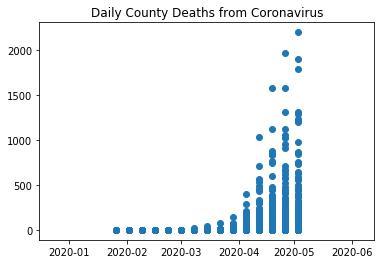

In [231]:
plt.scatter(df_joined['date'],df_joined['deaths'])
plt.title("Daily County Deaths from Coronavirus")
plt.show()

## Modeling

**Data Cleaning for Models**

In [232]:
simple_columns = ['fips_new','week','date', 'cases', 'deaths','mean_pm25']

In [233]:
demographic_columns = ['fips_new','week','date', 'cases', 'deaths','mean_pm25',
                                  'pct_native','popdensity','older_percent',
                                  'hispanic','Long_','population','population_frac_county', 
                                  'poverty', 'mean_summer_temp','Lat',
                                  'mean_winter_rm', 'education', 'mean_winter_temp',
                                  'pct_owner_occ', 'medhouseholdincome', 'medianhousevalue', 'pct_asian',
                                  'pct_white', 'pct_blk']

In [234]:
df_simple = df_joined[simple_columns]

df_simple = df_simple.groupby(['fips_new','week']).agg(
    cases=('cases', 'sum'), deaths=('deaths', 'sum'),
    mean_pm25 = ('mean_pm25','mean'))

df_simple=df_simple.reset_index()

In [235]:
X_train_simple = df_simple.loc[df_simple['week']<18 ][['mean_pm25','week']]
y_train_simple = df_simple.loc[df_simple['week']<18][['deaths']]
X_test_simple = df_simple.loc[df_simple['week']==18][['mean_pm25','week']]
y_test = df_simple.loc[df_simple['week']==18][['deaths']] #only need to filter y_test once for all models


In [236]:
df_demographic = df_joined[demographic_columns]

df_demographic = df_demographic.groupby(['fips_new','week']).agg(
    {
        'cases':'sum',
        'deaths':'sum',
        'mean_pm25':'mean',
        'pct_native':'mean',
        'popdensity':'mean',
        'older_percent':'mean',
        'hispanic':'mean',
        'Long_':'mean',
        'population':'mean',
        'population_frac_county':'mean', 
        'poverty':'mean', 
        'mean_summer_temp':'mean',
        'Lat':'mean',
        'mean_winter_rm':'mean', 
        'education':'mean', 
        'mean_winter_temp':'mean',
        'pct_owner_occ':'mean', 
        'medhouseholdincome':'mean', 
        'medianhousevalue':'mean', 
        'pct_asian':'mean',
        'pct_white':'mean', 
        'pct_blk':'mean'        
    })

df_demographic=df_demographic.reset_index()

In [237]:
X_train_demographic = df_demographic.loc[df_demographic['week']<18].drop(columns = ['fips_new','cases','deaths'])
y_train_demographic = df_demographic.loc[df_demographic['week']<18][['deaths']]
X_test_demographic = df_demographic.loc[df_demographic['week']==18].drop(columns = ['fips_new','cases','deaths'])


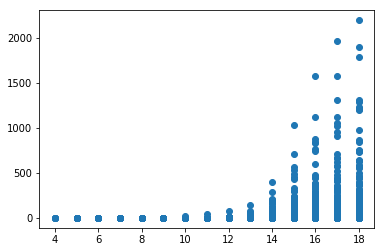

In [238]:
plt.scatter(df_simple['week'],df_simple['deaths'])
plt.title("")
plt.show()

#### Linear Regression

**Model 1:**
Simple Model uses only week number and the mean pm25 levels by county

In [239]:
from sklearn.linear_model import LinearRegression
model_simple = LinearRegression().fit(X_train_simple, y_train_simple)
y_pred_simple = model_simple.predict(X_test_simple)

In [240]:
from sklearn.metrics import mean_squared_error
mse_score_linear_simple = mean_squared_error(y_test, y_pred_simple)
mse_score_linear_simple #very bad score!

10430.460991883792

In [241]:
, y_test['deaths'].values.sum()

(41152.841612878095, 48829)

**Model 2:**
Add in demographic variables

In [242]:
model_demographic = LinearRegression().fit(X_train_demographic, y_train_demographic)
y_pred_demographic = model_demographic.predict(X_test_demographic)

In [243]:
mse_score_linear_demographic = mean_squared_error(y_test, y_pred_demographic)
mse_score_linear_demographic #pretty bad score!

8755.195509315537

In [249]:
print('Linear Regression predicted deaths, simple features: ', 
      round(y_pred_simple.sum().sum(),0)) 

print('Random Forest predicted deaths, add demographic features: ', 
      round(y_pred_demographic.sum(),0)) 

print("Actual deaths: ", y_test['deaths'].values.sum())

Linear Regression predicted deaths, simple features:  41153.0
Random Forest predicted deaths, add demographic features:  57867.0
Actual deaths:  48829


#### Decision Tree Models

In [250]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Training classifiers
boosting_simple = GradientBoostingRegressor(random_state=1, n_estimators=15).fit(X_train_simple.values, y_train_simple.values)
boosting_demographics = GradientBoostingRegressor(random_state=1, n_estimators=15).fit(X_train_demographic.values, y_train_demographic.values)
rf_simple = RandomForestRegressor(random_state=1, n_estimators=15).fit(X_train_simple.values, y_train_simple.values)
rf_demographics = RandomForestRegressor(random_state=1, n_estimators=15).fit(X_train_demographic.values, y_train_demographic.values)


/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/ericenglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ra

In [251]:
y_pred_boosting_simple = boosting_simple.predict(X_test_simple.values)
y_pred_boosting_demographic = boosting_demographics.predict(X_test_demographic.values)
y_pred_rf_simple = rf_simple.predict(X_test_simple.values)
y_pred_rf_demographic = rf_demographics.predict(X_test_demographic.values)

In [252]:
mse_score_boosting_simple = mean_squared_error(y_test, y_pred_boosting_simple)
mse_score_boosting_demographic = mean_squared_error(y_test, y_pred_boosting_demographic)
mse_score_rf_simple = mean_squared_error(y_test, y_pred_rf_simple)
mse_score_rf_demographic = mean_squared_error(y_test, y_pred_rf_demographic)

print('Boosting, simple features: ', round(mse_score_boosting_simple,0)) 
print('Boosting, add demographic features: ', round(mse_score_boosting_demographic,0)) 
print('Random Forest, simple features: ', round(mse_score_rf_simple,0)) 
print('Random Forest, add demographic features: ', round(mse_score_rf_demographic,0)) 

Boosting, simple features:  9001.0
Boosting, add demographic features:  4929.0
Random Forest, simple features:  1934.0
Random Forest, add demographic features:  1093.0


In [253]:
print('Boosting predicted deaths, simple features: ', 
      round(y_pred_boosting_simple.sum(),0))

print('Boosting predicted deaths, add demographic features: ', 
      round(y_pred_boosting_demographic.sum(),0)) 

print('Random Forest predicted deaths, simple features: ', 
      round(y_pred_rf_simple.sum(),0)) 

print('Random Forest predicted deaths, add demographic features: ', 
      round(y_pred_rf_demographic.sum(),0)) 

print("Actual deaths: ", y_test['deaths'].values.sum())

Boosting predicted deaths, simple features:  29623.0
Boosting predicted deaths, add demographic features:  23522.0
Random Forest predicted deaths, simple features:  35765.0
Random Forest predicted deaths, add demographic features:  35393.0
Actual deaths:  48829


#### RNNs

#### Extrapolate Models Until August